# Computing the mean using `Queue`

In this notebook, we compute the mean of an array of random numbers.  

Rather than import NumPy, we will use the `%pylab` magic command, which essentially is equivalent

    from numpy import *
    from scipy import *
    from matplotlib.pyplot import *

In [1]:
%matplotlib notebook
%pylab
import time, multiprocessing
import pandas

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


In [8]:
N = 2**28
x = random.rand(N)
print("Memory usage {:.2f} GB".format(N*8/1024**3))

Memory usage 2.00 GB


In [9]:
def vsum(x,q):
    q.put(sum(x))
    
def compute_mean(x,np):
    N = len(x)
    jobs = []
    q = multiprocessing.Queue()
    for i in range(np):
        i1 = int(i*N/np)
        i2 = int((i+1)*N/np)
        job = multiprocessing.Process(target=vsum,args=[x[i1:i2],q])
        jobs.append(job)
        
    for job in jobs:
        job.start()
    
    for job in jobs:
        job.join()
        
    s = 0
    while not q.empty():
        s += q.get()
        
    return s/N    

In [10]:
# Use 'timeit' loop
procs = 2**arange(0,6)
tdata = empty(procs.shape)
for i,np in enumerate(procs):
    tr = %timeit -n 2 -r 5 -q -o pass; compute_mean(x,np)
    tdata[i] = tr.best    

In [5]:
p = pandas.Series(procs,dtype='d')
t = pandas.Series(tdata,dtype='d')
df = pandas.DataFrame({'p' : p, 't' : t})
df

,p,t
0,1.0,1.122846
1,2.0,0.620346
2,4.0,0.361634
3,8.0,0.288690
4,16.0,0.298404
5,32.0,0.342689


<IPython.core.display.Javascript object>


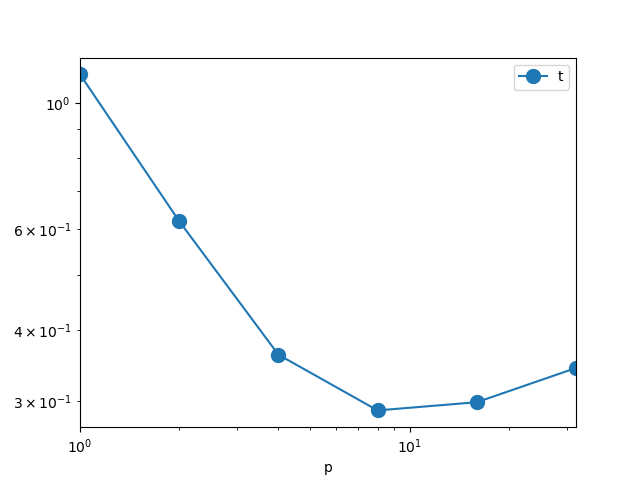

In [6]:
df.plot(x='p', logx=True, logy=True, style='.-',markersize=20)